In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torch.nn as nn
import torch.nn.functional as F

import os
import matplotlib.pyplot as plt
from PIL import Image

if not os.path.exists('./mnist_images'):
    os.mkdir('./mnist_images')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
latent_dim = 8
num_epochs = 20
batch_size = 128
learning_rate = 1e-3
b1 = 0.9
b2 = 0.999

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./mnist_images', train=True, download=True, transform=transform)
mnist_dataset = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

if not os.path.exists('./output_dir'):
    os.makedirs('./output_dir')

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17936336.80it/s]


Extracting ./mnist_images/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_images/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 495497.23it/s]


Extracting ./mnist_images/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_images/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4547538.10it/s]


Extracting ./mnist_images/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_images/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11346354.24it/s]

Extracting ./mnist_images/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_images/MNIST/raw



In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 32),
            nn.ReLU(True),
            nn.Linear(32, latent_dim)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [9]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.model = nn.Sequential(
      nn.Linear(latent_dim, 16),
      nn.ReLU(True),
      nn.Linear(16, 32),
      nn.ReLU(True),
      nn.Linear(32, 64),
      nn.ReLU(True),
      nn.Linear(64, 128),
      nn.ReLU(True),
      nn.Linear(128, 256),
      nn.ReLU(True),
      nn.Linear(256, 28 * 28),
      nn.Tanh()
    )


  def forward(self, x):
    x = self.model(x)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [10]:
class AutoEncoder(nn.Module):
  def __init__(self):
    super(AutoEncoder, self).__init__()

    self.encoder = Encoder().to(device)
    self.decoder = Decoder().to(device)


  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [11]:
autoencoder = AutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate, betas=(b1, b2))

In [12]:
autoencoder.train()

for e in range(num_epochs):
  for i, (images, _) in enumerate(mnist_dataset):
    images = images.to(device)
    outputs = autoencoder(images)
    loss = criterion(outputs, images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'
          .format(e + 1, num_epochs, loss.item()))

    if (e + 1) % 5 == 0 and i == len(mnist_dataset) - 1:
      pic = to_img(outputs.cpu().data)
      save_image(pic, './output_dir/image_{}.png'.format(e))


Streaming output truncated to the last 5000 lines.
epoch [10/20], loss:0.0841
epoch [10/20], loss:0.0876
epoch [10/20], loss:0.0832
epoch [10/20], loss:0.0779
epoch [10/20], loss:0.0839
epoch [10/20], loss:0.0894
epoch [10/20], loss:0.0810
epoch [10/20], loss:0.0837
epoch [10/20], loss:0.0895
epoch [10/20], loss:0.0945
epoch [10/20], loss:0.0811
epoch [10/20], loss:0.0768
epoch [10/20], loss:0.0792
epoch [10/20], loss:0.0824
epoch [10/20], loss:0.0880
epoch [10/20], loss:0.0816
epoch [10/20], loss:0.0868
epoch [10/20], loss:0.0807
epoch [10/20], loss:0.0737
epoch [10/20], loss:0.0861
epoch [10/20], loss:0.0904
epoch [10/20], loss:0.0893
epoch [10/20], loss:0.0818
epoch [10/20], loss:0.0860
epoch [10/20], loss:0.0869
epoch [10/20], loss:0.0864
epoch [10/20], loss:0.0770
epoch [10/20], loss:0.0889
epoch [10/20], loss:0.0747
epoch [10/20], loss:0.0804
epoch [10/20], loss:0.0835
epoch [10/20], loss:0.0870
epoch [10/20], loss:0.0872
epoch [10/20], loss:0.0819
epoch [10/20], loss:0.0778
epoc

In [ ]:
pic = to_img(outputs.cpu().data)
save_image(pic, './output_dir/image_{}.png'.format(num_epochs))

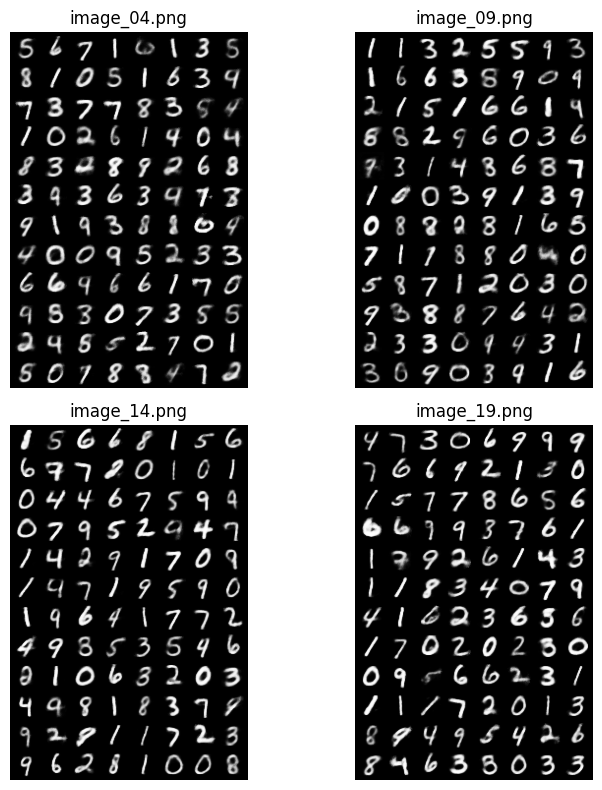

In [14]:
output_dir = './output_dir'
image_filenames = sorted([os.path.join(output_dir, f) for f in os.listdir(output_dir) if f.endswith('.png')])[:4]
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

axes = axes.flatten()
for ax, image_filename in zip(axes, image_filenames):
    img = Image.open(image_filename)
    ax.imshow(img, cmap='gray')
    ax.set_title(os.path.basename(image_filename))
    ax.axis('off')

plt.tight_layout()
plt.show()